In [1]:
import pandas 
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from pandas import Series
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import numpy
import copy

In [2]:
# create a differenced series
def difference(dataset, interval=1):
	data = copy.deepcopy(dataset)
	diff = list()
	for i in range(interval, len(data)):
		value = data[i] - data[i - interval]
		diff.append(value)
	return Series(diff)


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(dataFrame, lag=1):
	df = copy.deepcopy(dataFrame)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df



# scale train and test data to [-1, 1]
def scale(train, test):
	tra = copy.deepcopy(train)
	tes = copy.deepcopy(test)
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(tra)
	
	# transform train
	tra = tra.reshape(tra.shape[0], tra.shape[1])
	train_scaled = scaler.transform(tra)
	# transform test
	tes = tes.reshape(tes.shape[0], tes.shape[1])
	test_scaled = scaler.transform(tes)
	return scaler, train_scaled, test_scaled

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	tra = copy.deepcopy(train)
	X, y = tra[:, 0:-1], tra[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam', )
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X_ = copy.deepcopy(X)
	X_ = X_.reshape(1, 1, len(X_))
	yhat = model.predict(X_, batch_size=batch_size)
	return yhat[0,0]

In [3]:
# load dataset and turn into series
fullData = read_csv("../Data/Raw Data/fullData.csv")
daysToPredict = 5
sp500 = fullData.iloc[:, :8]
sp500 = sp500[["DATETIME", "ADJ CLOSE"]]
sp500 = sp500.set_index("DATETIME")
sp500Series = sp500["ADJ CLOSE"]

2022-12-13 22:34:01.518526: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 9ms/step
1) Test RMSE: 61.029
1/1 [==============================] - 0s 9ms/step
2) Test RMSE: 61.606
1/1 [==============================] - 0s 10ms/step
3) Test RMSE: 59.838
1/1 [==============================] - 0s 10ms/step
4) Test RMSE: 61.558
1/1 [==============================] - 0s 10ms/step
5) Test RMSE: 63.077
1/1 [==============================] - 0s 9ms/step
6) Test RMSE: 61.222
1/1 [==============================] - 0s 9ms/step
7) Test RMSE: 60.306
1/1 [==============================] - 0s 9ms/step
8) Test RMSE: 61.217
1/1 [==============================] - 0s 9ms/step
9) Test RMSE: 61.145
1/1 [==============================] - 0s 9ms/step
10) Test RMSE: 59.441
            rmse
count  10.000000
mean   61.043981
std     1.019362
min    59.441413
25%    60.486490
50%    61.181239
75%    61.473965
max    63.076664


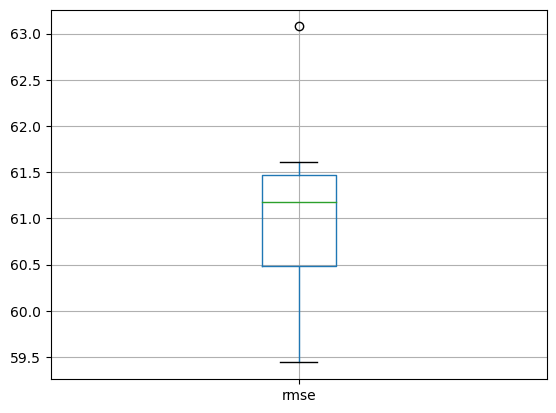

In [4]:
# transform data to be stationary
raw_values = sp500Series
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[:sp500.shape[0] - daysToPredict, :], supervised_values[sp500.shape[0] - daysToPredict + 1: , :]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
monteCarlo = 10
errorScores = list()
for r in range(monteCarlo):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 10, 10)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	predictions_history = list()
	
	X, y = train_scaled[-1, 0:-1], train_scaled[-1, -1]
	

	predictions_history.append(raw_values.iloc[:len(train)][-1])

	for i in range(len(test_scaled)+1):
		# make one-step forecast
		# X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X) #today

		X_old = X #yesterday

		X = numpy.array([yhat]) #today


		yhat = invert_scale(scaler, X_old, yhat) #today

		# X, yhat = numpy.array([yhat]), invert_scale(scaler, X, yhat)

		# # invert scaling
		# yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(predictions_history, yhat)

		predictions_history.append(yhat)

		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-(daysToPredict - 1):], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	errorScores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = errorScores
print(results.describe())
results.boxplot()
plt.show()

In [5]:
actual_for_report  = sp500.iloc[-(daysToPredict+60) + 1 : , 0]
date_time_report =  sp500.index[-(daysToPredict+60) + 1 :]
date_time_report = pandas.to_datetime(date_time_report)

pred = Series(predictions, index = sp500.iloc[(-(daysToPredict+60) + 1) + 60: , :].index)
sp500_60AndPredictBack = sp500.iloc[-(daysToPredict+60) + 1: (-(daysToPredict+60) + 1) + 60 , 0]
pred_for_report  = concat((sp500_60AndPredictBack, pred))

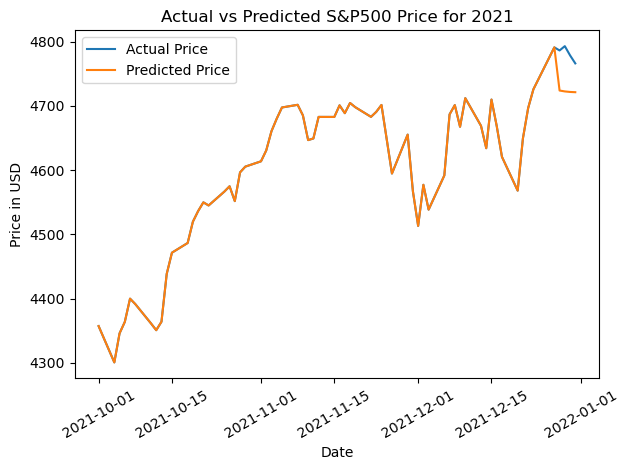

In [6]:
plt.plot(date_time_report, actual_for_report, label = 'Actual Price')
plt.plot(date_time_report, pred_for_report,label='Predicted Price')
plt.legend()
plt.title('Actual vs Predicted S&P500 Price for 2021')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [7]:
#average rmse
numpy.mean(results, axis=0)

rmse    61.043981
dtype: float64